# Ephys Code #

In [214]:
import pyabf
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import scipy.stats as sp
from scipy.interpolate import CubicSpline, interp1d
from scipy.signal import savgol_filter
from scipy.ndimage import gaussian_filter1d

In [215]:
# load abf
abf = pyabf.ABF("C:/Users/bbyer/OneDrive/Documents/UniversityofKentucky/BachstetterLab/ephys_toolbox/ephys_toolbox/data/2025_03_06_0000.abf")

In [216]:
sweep_list = abf.sweepList
num_traces = int(input("Enter number of stim sweeps: "))

In [217]:
sweep_indices = [sweep_list[i:i + num_traces] for i in range(0, len(sweep_list), num_traces)]

sweep_stims = ["amp25","amp50","amp75","amp100","amp150","amp200","amp250","amp300","amp400","amp500","amp600"]

def build_sweeps(abf, sweep_stims, sweep_indices, conversion_fct=1000):
    records = []
    for stim, idxs in zip(sweep_stims, sweep_indices):
        for sweep_id, i in enumerate(idxs, start=1):
            abf.setSweep(i)
            x = abf.sweepX.copy()
            y = abf.sweepY.copy()
            # Flatten into records
            for t, val in zip(x, y):
                records.append((stim, sweep_id, t, val))
    df = pd.DataFrame(records, columns=["stimulus", "sweep", "time", "value"])
    return df

df = build_sweeps(abf, sweep_stims=sweep_stims, sweep_indices=sweep_indices)
display(df)

,stimulus,sweep,time,value
0,amp25,1,0.00000,1.162720
1,amp25,1,0.00005,1.239014
2,amp25,1,0.00010,1.223755
3,amp25,1,0.00015,1.193237
4,amp25,1,0.00020,1.156616
...,...,...,...,...
16495,amp600,3,0.02475,0.762939
16496,amp600,3,0.02480,0.750732
16497,amp600,3,0.02485,0.762939
16498,amp600,3,0.02490,0.765991


In [218]:
def normalize_abf(abf_df):
    df = abf_df.copy()

    # subtract first point of each sweep
    df["t0"] = df.groupby(["stimulus", "sweep"])["value"].transform(lambda x: x.iloc[0])
    df["value"] = df["value"] - df["t0"]

    # reset time per sweep so each starts at 0
    df["time0"] = df.groupby(["stimulus", "sweep"])["time"].transform(lambda x: x.iloc[0])
    df["time"] = df["time"] - df["time0"]

    df.drop(columns=["t0", "time0"], inplace=True)
    return df

normalized = normalize_abf(df)

In [219]:
def remove_stim_artifact(abf_df, pulse_width=0.5e-3, fs=20e3, multiplier=3, std=2.0, K=60):
    """
    Remove stimulation artifact in sweeps using robust MAD detection + local interpolation.

    Parameters
    ----------
    abf_df : DataFrame with columns ["time", "value", "stimulus"]
        LFP sweeps grouped by 'stimulus'.
    pulse_width : float
        Stimulus pulse width (seconds per phase).
    fs : int
        Sampling frequency in Hz.
    multiplier : int
        How many pulse widths forward to mask after onset.
    std : float
        Threshold multiplier for robust MAD (default = 2).
    C: int
        Constant for amp stim removal padding
    """

    def process_group(group):
        g = group.copy()
        x = g["time"].to_numpy()
        y = g["value"].to_numpy()

        # calculate derivative + MAD threshold
        dy = np.gradient(y, x)

        search_window_sec = multiplier * pulse_width
        search_window_samples = int(search_window_sec * fs)

        slope_window = dy[:search_window_samples]
        med_dy = np.median(slope_window)
        mad_dy = np.median(np.abs(slope_window - med_dy))
        T = 1.4826
        thr_dy = std * T * mad_dy

        # detect slope outliers in axis = 0
        outliers = np.where(np.abs(slope_window) > thr_dy)[0]

        if len(outliers) == 0:
            g["clean"] = y
            return g
        
        # artifact bounds
        start_idx = max(1, outliers[0] - 1)
        end_idx   = min(len(x) - 2, outliers[-1] + 1)
       
        stim = g["stimulus"].iloc[0]   # e.g. "amp25"
        amp  = int(stim.replace("amp", ""))
        pad  = int(round(K / np.sqrt(amp)))

        # anchors with ±pad
        lo = max(0, start_idx - pad)
        hi = min(len(x) - 1, end_idx + pad)

        y_fixed = y.copy()
        mask_bad = (x >= x[lo]) & (x <= x[hi])
        
        # linear interpolation
        y_fixed[mask_bad] = np.interp(
            x[mask_bad],
            [x[lo], x[hi]],
            [y[lo], y[hi]]
        )

        g["clean"] = y_fixed
        return g

    return abf_df.groupby("stimulus", group_keys=False)[['stimulus', 'sweep', 'time', 'value']].apply(process_group)

removed = remove_stim_artifact(abf_df=normalized)
display(removed)

,stimulus,sweep,time,value,clean
0,amp25,1,0.00000,0.000000,0.000000
1,amp25,1,0.00005,0.076294,0.000000
2,amp25,1,0.00010,0.061035,0.000000
3,amp25,1,0.00015,0.030518,0.000000
4,amp25,1,0.00020,-0.006104,0.000000
...,...,...,...,...,...
16495,amp600,3,0.02475,-0.167847,-0.167847
16496,amp600,3,0.02480,-0.180054,-0.180054
16497,amp600,3,0.02485,-0.167847,-0.167847
16498,amp600,3,0.02490,-0.164795,-0.164795


In [220]:
def average_traces(abf_df):
    df_summary = (
        abf_df
        .groupby(["stimulus", "time"])
        .agg(
            mean_value=("clean", "mean"),
            sem_value=("clean", lambda x: x.std(ddof=1)/np.sqrt(len(x))) # standard error of the mean, std/sqrt(n)
        )
        .reset_index()
    )
    return df_summary

averaged = average_traces(removed)
display(averaged)

,stimulus,time,mean_value,sem_value
0,amp100,0.00000,0.000000,0.000000
1,amp100,0.00005,-0.045776,0.000000
2,amp100,0.00010,-0.042089,0.000000
3,amp100,0.00015,-0.038401,0.000000
4,amp100,0.00020,-0.034714,0.000000
...,...,...,...,...
5495,amp75,0.02475,0.022380,0.010620
5496,amp75,0.02480,0.014242,0.007121
5497,amp75,0.02485,0.026449,0.007945
5498,amp75,0.02490,0.025431,0.017383


In [221]:
def smooth_curves(abf_df, method="gaussian", win_len=40, poly=2, K=60):
    def process_group(group):
        g = group.copy()
        mean = g["mean_value"].to_numpy()

        if method == "gaussian":
            stim = g["stimulus"].iloc[0]   # e.g. "amp25"
            amp  = int(stim.replace("amp", ""))
            sigma  = int(round(K / np.sqrt(amp)))
            mean_smooth = gaussian_filter1d(mean, sigma=sigma, mode="reflect")
        if method == "savgol":
            mean_smooth = savgol_filter(mean, window_length=win_len, polyorder=poly, mode="interp")
        
        g["mean_smooth"] = mean_smooth

        return g
    
    return abf_df.groupby("stimulus", group_keys=False)[['stimulus', 'time', 'mean_value', 'sem_value']].apply(process_group)
smoothed = smooth_curves(averaged)
display(smoothed)

,stimulus,time,mean_value,sem_value,mean_smooth
0,amp100,0.00000,0.000000,0.000000,-0.027043
1,amp100,0.00005,-0.045776,0.000000,-0.026734
2,amp100,0.00010,-0.042089,0.000000,-0.026114
3,amp100,0.00015,-0.038401,0.000000,-0.025183
4,amp100,0.00020,-0.034714,0.000000,-0.023941
...,...,...,...,...,...
5495,amp75,0.02475,0.022380,0.010620,0.022019
5496,amp75,0.02480,0.014242,0.007121,0.022228
5497,amp75,0.02485,0.026449,0.007945,0.022395
5498,amp75,0.02490,0.025431,0.017383,0.022511


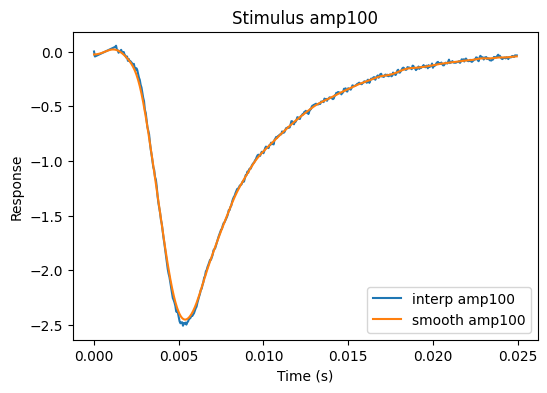

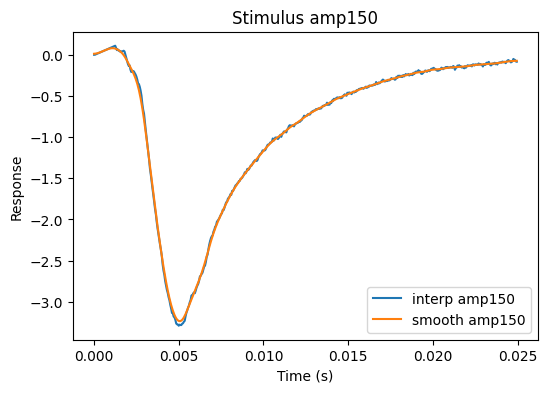

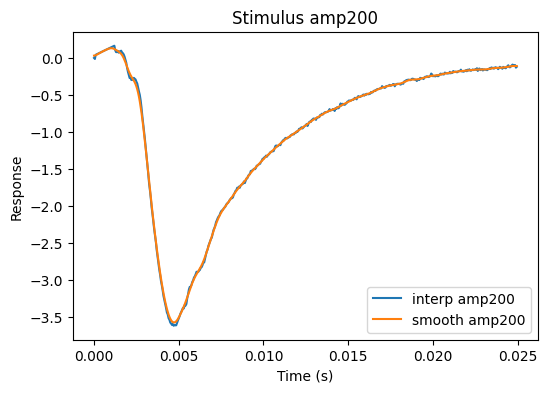

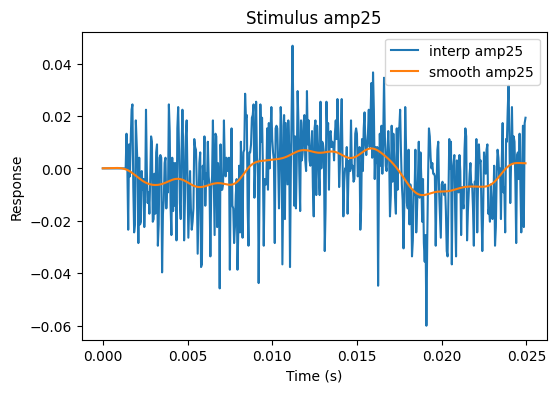

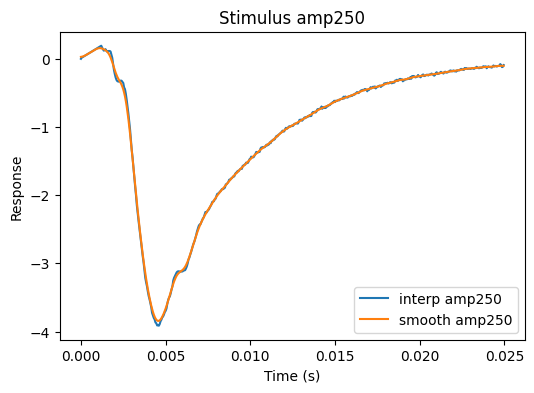

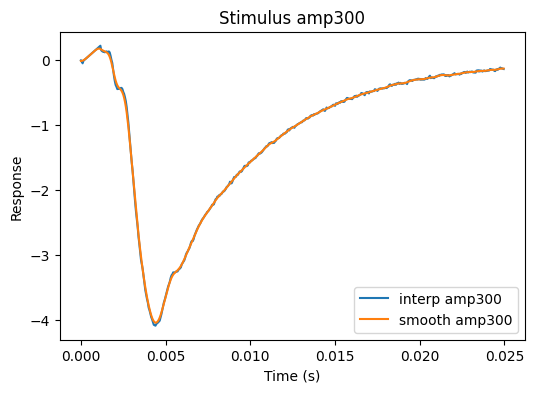

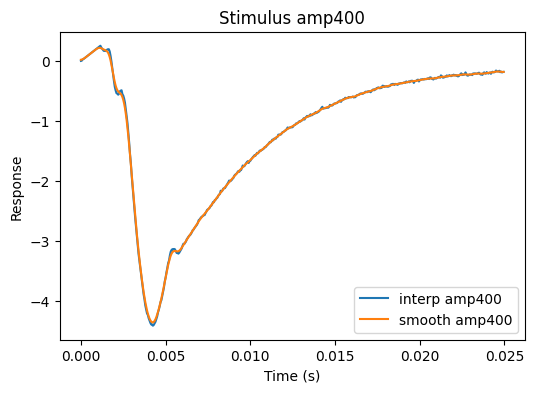

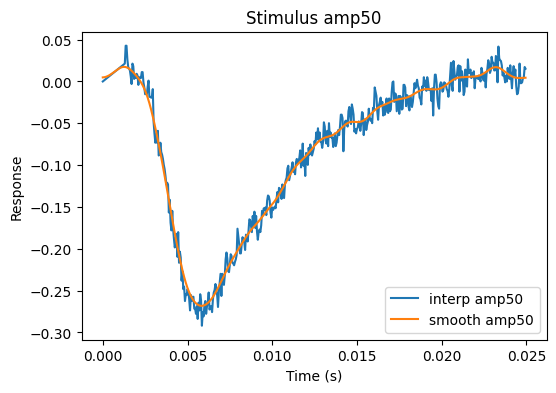

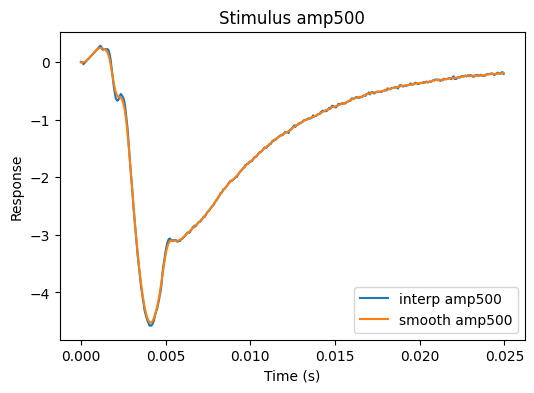

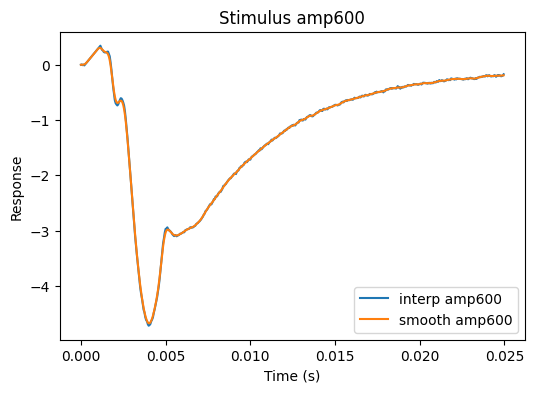

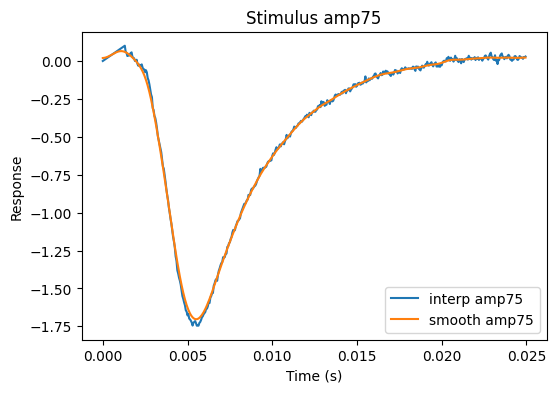

In [ ]:
def plot_traces(df_summary):
    for stim, sub in df_summary.groupby("stimulus"):
        plt.figure(figsize=(6,4))
        plt.plot(sub["time"] , sub["mean_value"], label=f"interp {stim}")
        plt.plot(sub["time"], sub["mean_smooth"], label=f"smooth {stim}")
        plt.title(f"Stimulus {stim}")
        plt.xlabel("Time (s)")
        plt.ylabel("Response")
        plt.legend()
        plt.show()

plot = plot_traces(smoothed)